Quantitative Seismic Interpretation
==================

This notebook provides a step-by-step walkthrough of a reservoir characterization workflow based on an example data-set and problem-set from Quantitative Seismic Interpretation (Avseth, Mukerji, Mavko, 2005).

The dataset used is provided free of charge on the QSI website (link). It consists of well log data from five wells, with six distinct lithofacies identified in Well 2, chosen as the type well. Alongside the well log data ia a seismic dataset containing on 2D section of NMO-corrected pre-stack CDP gathers and two 3D volumes - near and far offset partial stacks.

Rock physics modeling
----------------------

First off, we'll need to load the Well 2 data. The LAS file contains both P and S velocity, density, and gamma ray curves. We'll use the LASReader from SciPy recipes (link)

In [1]:
%matplotlib inline
from rppy import las
from rppy import rppy
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

well2 = las.LASReader("data/well_2.las", null_subs=np.nan)

First things first, let's take a look at our well logs. Most of the code below isn't necessary just to get a quick look, but it makes the plots nice and pretty.

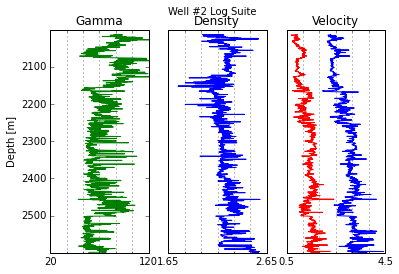

In [2]:
plt.figure(1)
plt.suptitle("Well #2 Log Suite")

plt.subplot(1, 3, 1)
plt.plot(well2.data['GR'], well2.data['DEPT'], 'g')
plt.ylim(2000, 2600)
plt.title('Gamma')
plt.xlim(20, 120)
plt.gca().set_xticks([20, 120])
plt.gca().xaxis.grid(True, which="minor")
minorLoc = AutoMinorLocator(6)
plt.gca().xaxis.set_minor_locator(minorLoc)
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.gca().set_yticks([2100, 2200, 2300, 2400, 2500])

plt.subplot(1, 3, 2)
plt.plot(well2.data['RHOB'], well2.data['DEPT'], 'b')
plt.ylim(2000, 2600)
plt.title('Density')
plt.xlim(1.65, 2.65)
plt.gca().set_xticks([1.65, 2.65])
plt.gca().xaxis.grid(True, which="minor")
minorLoc = AutoMinorLocator(6)
plt.gca().xaxis.set_minor_locator(minorLoc)
plt.gca().invert_yaxis()
plt.gca().axes.get_yaxis().set_ticks([])

plt.subplot(1, 3, 3)
plt.plot(well2.data['Vp'], well2.data['DEPT'], 'b')
plt.ylim(2000, 2600)
plt.title('VP')
plt.xlim(0.5, 4.5)
plt.gca().set_xticks([0.5, 4.5])
plt.gca().xaxis.grid(True, which="minor")
minorLoc = AutoMinorLocator(6)
plt.gca().xaxis.set_minor_locator(minorLoc)
plt.gca().invert_yaxis()
plt.gca().axes.get_yaxis().set_ticks([])

plt.plot(well2.data['Vs'], well2.data['DEPT'], 'r')
plt.ylim(2000, 2600)
plt.title('Velocity')
plt.xlim(0.5, 4.5)
plt.gca().set_xticks([0.5, 4.5])
plt.gca().xaxis.grid(True, which="minor")
minorLoc = AutoMinorLocator(6)
plt.gca().xaxis.set_minor_locator(minorLoc)
plt.gca().invert_yaxis()
plt.gca().axes.get_yaxis().set_ticks([])
plt.show()

Now, we'll derive a porosity curve from the bulk density assuming a uniform grain density of 2.65 g/cm^3 and a fluid density of 1.05 g/cm^3.

In [3]:
phi = (well2.data['RHOB'] - 2.65)/(1.05 - 2.65)

Let's take a look at our porosity curve and sanity-check it.

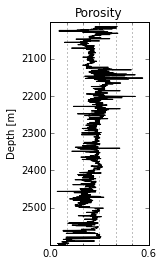

In [4]:
plt.figure(2)

plt.subplot(1, 3, 1)
plt.plot(phi, well2.data['DEPT'], 'k')
plt.ylim(2000, 2600)
plt.title('Porosity')
plt.xlim(0, 0.6)
plt.gca().set_xticks([0, 0.6])
plt.gca().xaxis.grid(True, which="minor")
minorLoc = AutoMinorLocator(6)
plt.gca().xaxis.set_minor_locator(minorLoc)
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.gca().set_yticks([2100, 2200, 2300, 2400, 2500])
plt.show()

Looks plausible, no values above 0.6, average porosity hovering around or below 30%. Now let's start looking at log relationships. We'll create a crossplot of Vp vs. Porosity for well 2, and colour it by gamma as a quick-look lithology indicator.

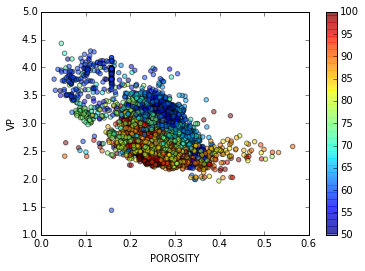

In [5]:
plt.figure(3)
fig, ax = plt.subplots()
im = plt.scatter(phi, well2.data["Vp"], s=20, c=well2.data["GR"], alpha=0.5)
plt.xlabel('POROSITY')
plt.ylabel('VP')
plt.xlim([0, 0.6])
plt.ylim([1, 5])
plt.clim([50, 100])
cbar = fig.colorbar(im, ax=ax)
plt.show()

We'll now compute the Hashin-Shtrikman upper and lower bounds, and add them to our crossplot. In order to do this, we'll need to make some assumptions about the composition of the rock. We'll assume a solid quartz matrix, with a bulk modulus K=37 GPa and a shear modulus u=44 GPa. For the fluid phase we'll begin by using water-filled porosity, by assuming a fluid bulk modulus K=2.25 GPa, shear modulus u=0 GPa.

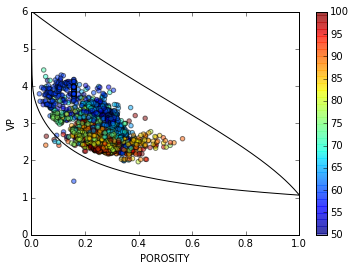

In [21]:
phi_2 = np.arange(0, 1, 0.001)
Ku = np.empty(np.shape(phi_2))
Kl = np.empty(np.shape(phi_2))
uu = np.empty(np.shape(phi_2))
ul = np.empty(np.shape(phi_2))
Vpu = np.empty(np.shape(phi_2))
Vpl = np.empty(np.shape(phi_2))

K = np.array([37, 3])
u = np.array([44, 0.01])
for n in np.arange(0, len(phi_2)):
    Ku[n], Kl[n], uu[n], ul[n] = rppy.hashin_shtrikman(K, u, np.array([1-phi_2[n], phi_2[n]]))
    Vpu[n] = rppy.Vp(2.65, K=Ku[n], u=uu[n])
    Vpl[n] = rppy.Vp(2.65, K=Kl[n], u=ul[n])

plt.figure(4)
fig, ax = plt.subplots()
im = plt.scatter(phi, well2.data["Vp"], s=20, c=well2.data["GR"], alpha=0.5)
plt.xlabel('POROSITY')
plt.ylabel('VP')
plt.xlim([0, 1])
plt.ylim([0, 6])
plt.clim([50, 100])
cbar = fig.colorbar(im, ax=ax)
plt.plot(phi_2, Vpu, 'k')
plt.plot(phi_2, Vpl, 'k')
plt.show()